In [203]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import torch

# 0. Motivation and Plan

The idea is quite simple: build a bot that can beat the game geoguessr. This game places players at random places around the world (in google street view) and players have to guess their location on the map. But I dont know web dev stuff so I cant make it automatically play the game. I only have a RTX 3090, and department has no GPU clusters, additionally it costs way too much money to grab images for more than 40k-ish locations. Therefore I will be restricting this to **United States** only. Geoguessr also has a USA only mode, so its a valid choice. Nevertheless, the plan:

1. get valid street adresses form https://batch.openaddresses.io/
2. do some filtering and preprocessing 
3. sample out valid coordinates into train/val/test
4. use Google Cloud Platform's Street View Static API to grab 5 images of res 448x448 at headings: (0,72,144,216,288). Then stitch them together.
5. Take a pretrained backbone, in thise case I chose [ConVNeXt-base](https://github.com/facebookresearch/ConvNeXt) pretrained on the larger ImageNet-22k dataset. Reasoning:
   
   1. General transfer learning reasons: stuff in the 22,000 classes will probably be in the street view images, so we save time as the model will converge faster due to the initial layers extracting similar features, etc...
   2. Why not resnet18/50/101? I wanted to play with a bigger model

6. Then we can have the model predict the latitude and longitude of the image. We train the model via a $Smooth-L1$ Loss function. I called this the "naive" model, or the regression only model. Question:

   1. Why not MSE? I didn't have enough time to try different loss functions, and from previous experience $Smooth-L1$ tends to outperform MSE, so I went with that.

7. The second approach, we borrow ideas from object detection. We use two branches after the backbone. 1. predict the class of the image, in this case, which state it belongs to. 2. have the regression branch predict the residual of the exact location $\Delta Lat, \Delta Lon$ from the average position of the state. classification head is supervised by cross entropy loss, regression head is still $Smooth-L1$
   1. The average position of the state is defined to be the average of the latitude and longitude of all the training samples.
   2. This way, the hypothesis class is hypothetically restricted and hence much smaller, so we expect this model to perform better.
8. We can then compare our two models to the following baselines:
   1. randomly guessing a point 
   2. always choosing the geographic center of the USA



# 1. Creating Dataset

After downloading the `.geojson` files from https://batch.openaddresses.io/data. Run `create_data.py` to create and partition the dataset. This script utilizes a set of preprocessing and partitioning functions defined in the `Datatools` calss at `utils/data_utils.py` 

!! Important observation !!

We CANNOT randomly sample locations to split our dataset! One can imagine that random splitting may cause class imbalance. E.g. The train split to contain ONLY west coast states. While I tried to ensure that there are the same number of images for each state, the number of invalid positions varied for each state during the image retrival process. This was a design oversight and one can definitely fix it such that all states have the same number of images. Nevertheless lets examine our train/val/test distributions

In [48]:
from utils.train_utils import create_datasets_and_loaders
from collections import defaultdict
from pathlib import Path
import pandas as pd
all_datasets, all_dataloaders =  create_datasets_and_loaders(
        '/home/gabriel/guesser/data/images',
        '/home/gabriel/guesser/data/labels',
        batch_size=16,
        with_bin=None
)

train = all_datasets['train']
val = all_datasets['val']
test = all_datasets['test']

In [52]:
# TRAIN SET
num_images = defaultdict(int)
for state in train.image_paths:
    num_images[Path(state).stem[:2]] += 1 
for k,v in num_images.items():
    num_images[k] = [v]
train_pd = pd.DataFrame(num_images).T
# display(train_pd)

<AxesSubplot:>

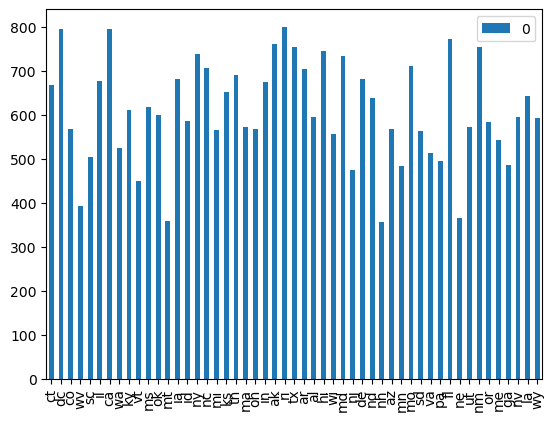

In [53]:
train_pd.plot(kind='bar')

In [54]:
# VAL SET
num_images = defaultdict(int)
for state in val.image_paths:
    num_images[Path(state).stem[:2]] += 1 
for k,v in num_images.items():
    num_images[k] = [v]
val_pd = pd.DataFrame(num_images).T
# display(val_pd)

<AxesSubplot:>

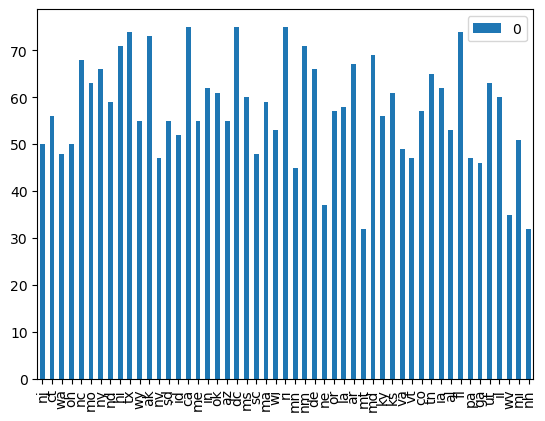

In [55]:
val_pd.plot(kind='bar')

In [56]:
# TEST SET
num_images = defaultdict(int)
for state in test.image_paths:
    num_images[Path(state).stem[:2]] += 1 
for k,v in num_images.items():
    num_images[k] = [v]
test_pd = pd.DataFrame(num_images).T
# display(test_pd)

<AxesSubplot:>

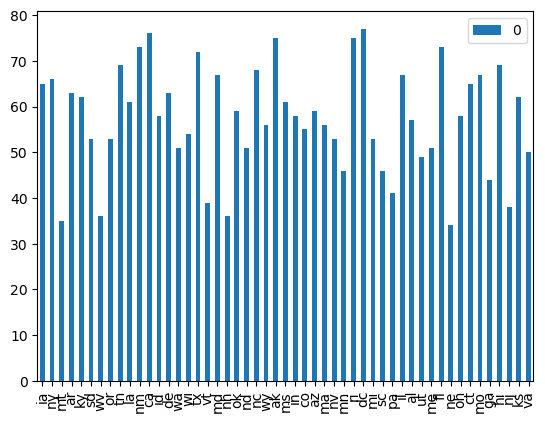

In [57]:
test_pd.plot(kind='bar')

In [58]:
print(len(train))
print(len(val))
print(len(test))

31045
2925
2925


So:
train set: 31045 Images
val set: 2925 Images
test set: 2925 Images

A 84/8/8 split

in hindset the train set is probably too large, but bit too late now. I suppose one can either re-split the images, or just add more images to the val/test set. Anyways its what we have for now.

# 2. Training the Model

There isn't much to say here, the training details can be found in `main.py`, hyperparameter choices may not be ideal, but both model still converged, so "good enough" I suoppose. with 31k Images, I was able to train with a batch size of 7 if I used mixed precision @50min/epoch, or batch size of 4 if full precision. I trained both models until the validation curve flattened and picked the model checkpoint corresponding to the lowest val loss.

# 3. Results

The tensorboard logs are available at `results/*` but I messed up the logging when training the naive model, and the first few epochs for the bin based model. So its not very readable. Nevertheless, the test results are what matters, so lets check them out.


`test.py` script runs both models on the test set and saves the predicted positions (and states), and labels.  

In [190]:
from math import radians, cos, sin, asin, sqrt,pi

def haversine(coord1,coord2):
    """
    lat,lon format
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lat1,lon1 = coord1[0],coord1[1]
    lat2,lon2 = coord2[0],coord2[1]

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def print_stats(alist):
    print(f'min: {min(alist)}')
    print(f'average: {np.average(alist)}')
    print(f'median: {np.median(alist)}')
    print(f'max: {max(alist)}')

In [191]:

naive_pred_position = np.load('results/plainreg_predictions.npy')
naive_true_labels = np.load('results/plainreg_labels.npy')

bb_pred_class = np.load('results/binbased_class.npy')
bb_pred_position = np.load('results/binbased_pos.npy')

labels = np.load('results/binbased_labels.npy')
bb_true_class = labels[:,0]
bb_true_position = labels[:,1:3]

## Naive Model

lets check out the differences between the predictions and labels

In [192]:
naive_distances = []
for i in range(len(naive_pred_position)):
    naive_distances += [haversine(naive_pred_position[i],naive_true_labels[i])]

naive_distances = np.array(naive_distances)

In [193]:
print_stats(naive_distances)
px.histogram(naive_distances)


min: 1.0404492130103218
average: 265.765085275177
median: 176.07121189223108
max: 5929.595521070166


# Bin based model
For the bin based model, we can look at its classification and regression results

In [101]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class2states = {}
for k,v in train.state2class.items():
    class2states[v] = k

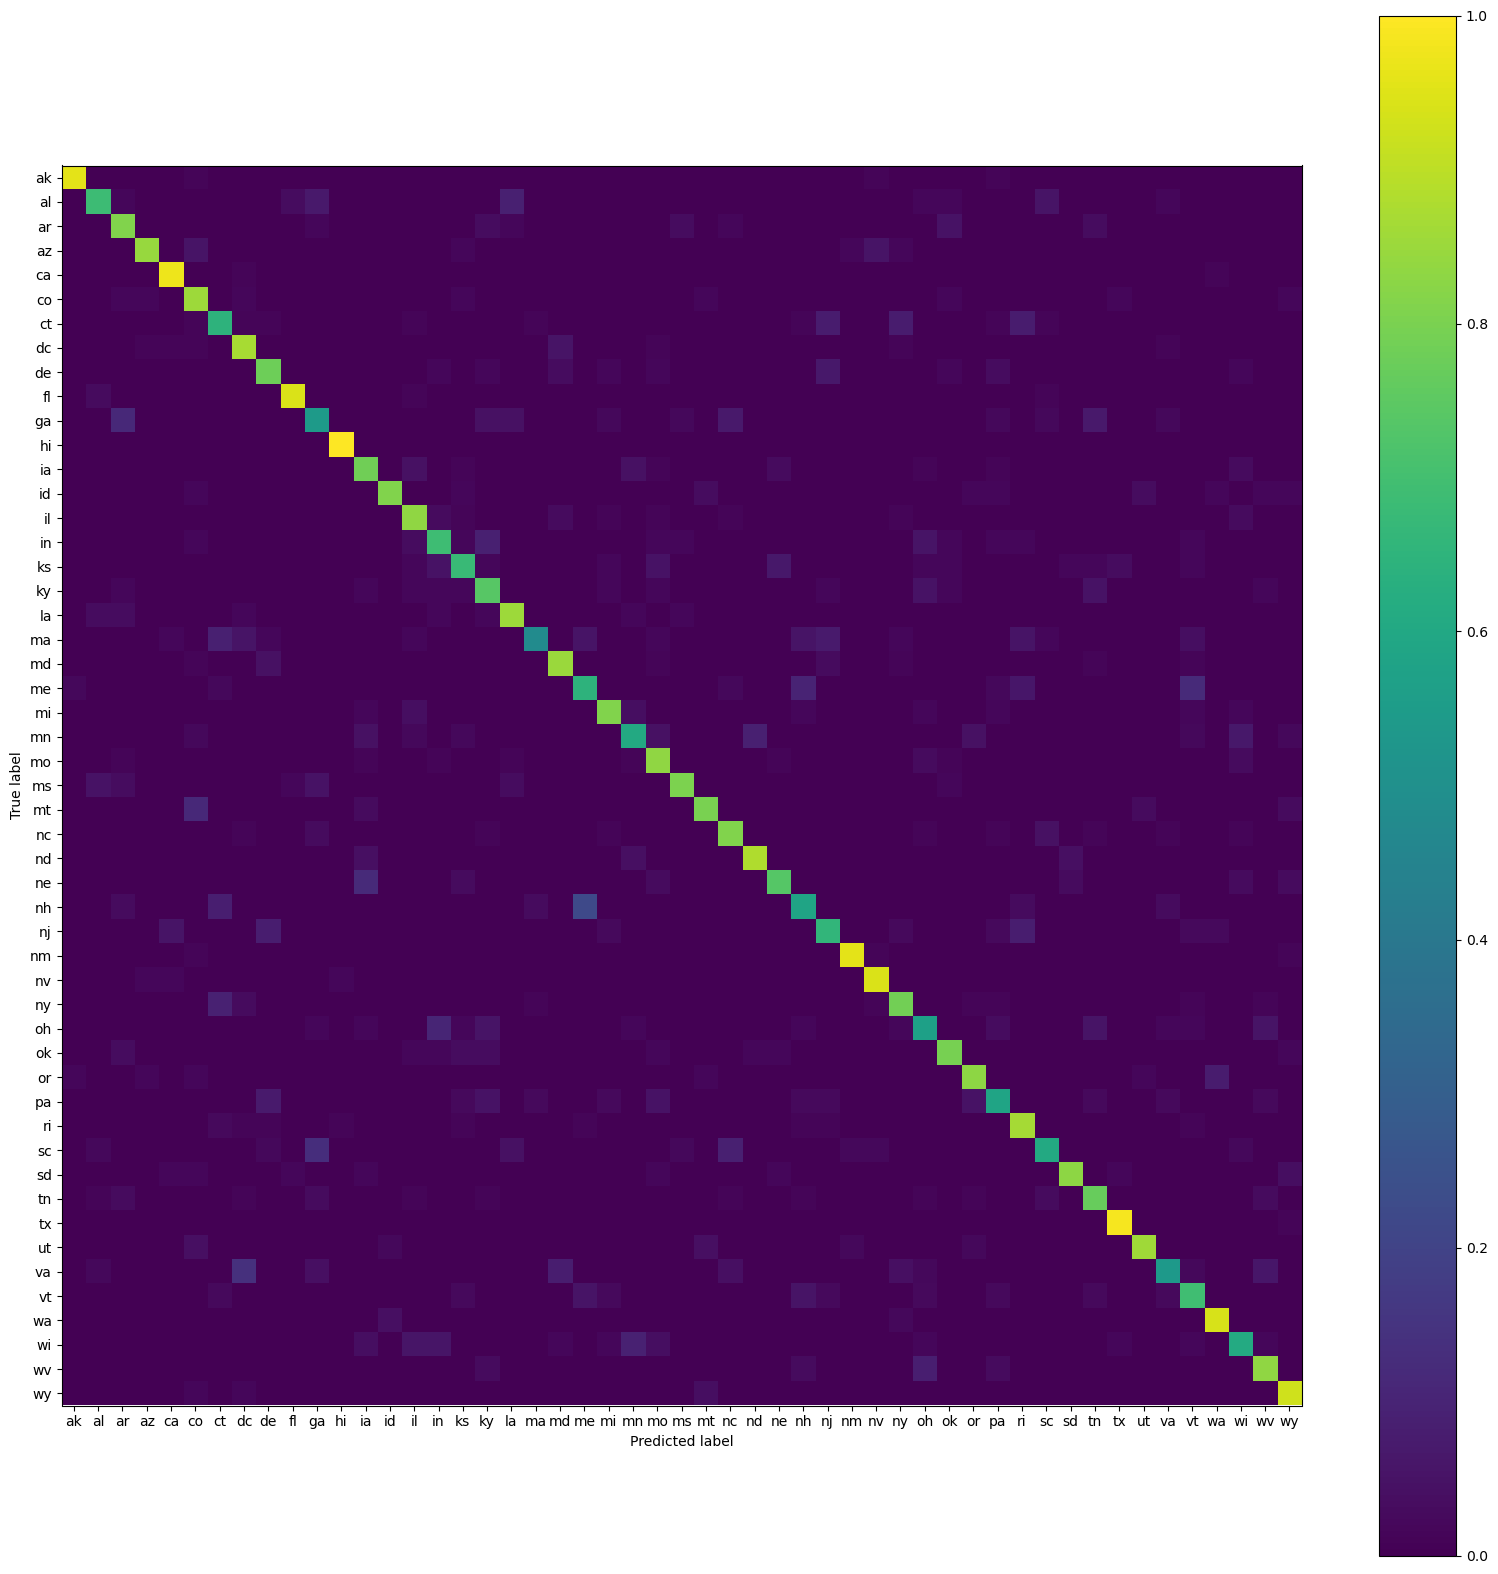

In [132]:
bb_predicted_states = [class2states[c] for c in bb_pred_class]
bb_true_states = [class2states[c] for c in bb_true_class]
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(bb_true_states,bb_predicted_states,include_values=False,normalize='true',ax = ax)

In [133]:
bb_distances = []
for i in range(len(bb_pred_position)):
    bb_distances += [haversine(bb_pred_position[i],bb_true_position[i])]

bb_distances = np.array(bb_distances)

In [194]:
print_stats(bb_distances)
px.histogram(bb_distances)


min: 0.23834930484372996
average: 166.50394687000409
median: 28.229833816573855
max: 8166.944852519033


# Analysis 
Lets compare the models. (some issues with plotly hist, so stuck with non-interactive plt :< )

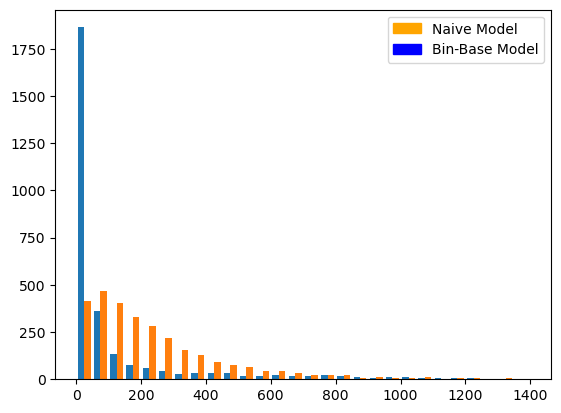

In [177]:
# We're cutting off distances >= 1500ish just for visualization's sake
import matplotlib.patches as mpatches
plt.hist([bb_distances,naive_distances],bins=range(0, int(max(bb_distances))//6 + 50, 50))
naive = mpatches.Patch(color='orange', label='Naive Model')
bb = mpatches.Patch(color='blue', label='Bin-Base Model')
plt.legend(handles=[naive,bb])
plt.show()

So we see that the bin based model is much more accuract *and* precise as well. One explaination is that our model is really good at predicting which state the picture belongs to. If it is correct, then most likely going to be within the state borders. Take Colorado for example, it's width and height is 450 and 610km. So if our model predicts Colorado, with residual of 0 for lat and lon. the most wrong it can be is around 380km. Let see the distances when we look at correctly classified predictions, vs incorrect ones.

In [195]:
dist_when_correct = bb_distances[bb_pred_class == bb_true_class]
print_stats(dist_when_correct)


min: 0.23834930484372996
average: 35.49445055904594
median: 20.204324840559774
max: 830.0287704333202


In [198]:
dist_when_wrong = bb_distances[bb_pred_class != bb_true_class]
print_stats(dist_when_wrong)

min: 10.912545537693736
average: 667.842266911443
median: 436.026022068148
max: 8166.944852519033


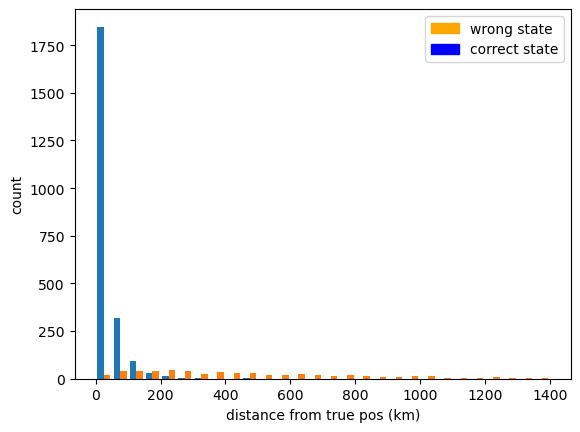

In [188]:
plt.hist([dist_when_correct,dist_when_wrong],bins=range(0, int(max(dist_when_wrong))//6 + 50, 50))
naive = mpatches.Patch(color='orange', label='wrong state')
bb = mpatches.Patch(color='blue', label='correct state')
plt.legend(handles=[naive,bb])
plt.xlabel('distance from true pos (km)')
plt.ylabel('count')
plt.show()

Which matches our intuition

# 4. Qualitative Visual Analysis

lets visualize our results by plotting the top 50 predictions for both

In [212]:
# plots stuff on map
def plot_map_results(predictions,labels,type_name='best',model_name='bin based'):

    color = 'green' if type_name == 'best' else 'red'


    idx = np.array([range(0,len(predictions))]).T
    best_idx = np.array([[f'{type_name}_{i.item()}' for i in idx]]).T

    # best_pred_with_label = np.hstack((best_pred,best_idx))
    # best_labels_with_label = np.hstack((best_labels,best_idx))

    
    # type = np.array([['best' for i in range(len(idx))]]).T
    combined_idx = np.array([[f'{type_name}{i.item()}' for i in idx]]).T
    pred_name = np.array([[f'prediction{i}' for i in range(len(idx))]]).T
    label_name = np.array([[f'label{i}' for i in range(len(idx))]]).T



    predictions_info = np.hstack((predictions,pred_name,idx,combined_idx))
    labels_info = np.hstack((labels,label_name,idx,combined_idx))


    # DATAFRAME FOR PLOTTING LOCATIONS 
    locations_df = pd.DataFrame(predictions_info, columns=['lat','lon','type','idx','marker'])
    locations_df = locations_df.append(pd.DataFrame(labels_info, columns=['lat','lon','type','idx','marker']))
    locations_df = locations_df.astype({'lat': 'float','lon':'float','idx':'int'})



    line_df = pd.DataFrame(np.hstack((predictions,labels)),columns=['start_lat','start_lon','end_lat','end_lon'])


    fig = go.Figure()

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = locations_df['lon'],
        lat = locations_df['lat'],
        hoverinfo = 'text',
        text = locations_df['type'],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = color,
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = f'{type_name} {len(predictions)} predictions for model:{model_name}',
        showlegend = False,
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )


    for i in range(len(line_df)):
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [line_df['start_lon'][i], line_df['end_lon'][i]],
                lat = [line_df['start_lat'][i], line_df['end_lat'][i]],
                mode = 'lines',
                line = dict(width = 1,color = color),
                # opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
            )
        )

    fig.show()

In [215]:
v,idx = torch.topk(torch.tensor(bb_distances),50,largest=False)
plot_map_results(bb_pred_position[idx],bb_true_position[idx])

/tmp/ipykernel_3697797/1576150564.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [214]:
v,idx = torch.topk(torch.tensor(naive_distances),50,largest=False)


plot_map_results(naive_pred_position[idx],bb_true_position[idx],model_name='naive')

/tmp/ipykernel_3697797/1576150564.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Worst 50

In [217]:
v,idx = torch.topk(torch.tensor(bb_distances),50)


plot_map_results(bb_pred_position[idx],bb_true_position[idx],type_name='worst',model_name='bin-based')

/tmp/ipykernel_3697797/1576150564.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [218]:
v,idx = torch.topk(torch.tensor(naive_distances),50)


plot_map_results(naive_pred_position[idx],bb_true_position[idx],type_name='worst',model_name='naive')

/tmp/ipykernel_3697797/1576150564.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

